In [1]:
from pathlib import Path

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

import shap


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
data = pd.read_parquet('../postech_company_project_2.parquet')

# take all data where "TO_RECLAIM" is 1
# and take the same number of data where "TO_RECLAIM" is 0 sampled randomly
# this is to avoid overfitting
to_reclaim_count = data[data['TO_RECLAIM'] == 1].shape[0]
not_to_reclaim_count = data[data['TO_RECLAIM'] == 0].shape[0]

sample_count = min(to_reclaim_count, not_to_reclaim_count)
data = pd.concat([data[data['TO_RECLAIM'] == 0].sample(n=sample_count),
                  data[data['TO_RECLAIM'] == 1].sample(n=sample_count)])

# check if the data is balanced
data['TO_RECLAIM'].value_counts()


TO_RECLAIM
0    358704
1    358704
Name: count, dtype: int64

In [3]:
remove_cols = ['MULTICLAIM', 'RECLAIM_PERIOD', 'PARTS_DESC1', 'PARTS_DESC2', 'PARTS_DESC3', 'PARTS_DESC4', 'PARTS_DESC5', 'PREV_PARTS_DESC1', 'PREV_PARTS_DESC2', 'PREV_PARTS_DESC3', 'PREV_PARTS_DESC4', 'PREV_PARTS_DESC5', 'TO_RECLAIM_NUMBER', 'YEAR_YYYY', 'MONTH_YYYYMM', 'PREV_RECEIPT_NUMBER', 'RECEIPT_NUMBER', 'ENGINEER_CODE', 'ENGINEER_SYMPTOM', 'ENGINEER_REPAIR', 'PARTS_NO1', 'PARTS_NO2', 'PARTS_NO3', 'PARTS_NO4', 'PARTS_NO5', 'KEY_PARTS1', 'KEY_PARTS2', 'KEY_PARTS3', 'KEY_PARTS4', 'KEY_PARTS5', 'KEY_PARTS_REMARK1', 'KEY_PARTS_REMARK2', 'KEY_PARTS_REMARK3', 'KEY_PARTS_REMARK4', 'KEY_PARTS_REMARK5']
target = 'TO_RECLAIM'

# drop data in remove_cols
data1 = data.drop(columns=remove_cols)

display(data1.head())

categorical_columns = [col for col in data1.columns if col != target and data1[col].dtype == 'object']
mapping = {}
for col in categorical_columns:
    data1[col], mapping[col] = pd.factorize(data1[col], use_na_sentinel=True)

# Replace NaNs with -1
data1.fillna(-1, inplace=True)

display(data1.head())

features = [col for col in data1.columns if col != target]
X_train, X_valid, y_train, y_valid = train_test_split(data1[features], data1[target], test_size=0.2, random_state=0)
dt = xgb.DMatrix(X_train, label=y_train)
dv = xgb.DMatrix(X_valid, label=y_valid)


,WEEK_YYYYWWW,SUBSIDIARY_NAME,CAPTIVE_CHANNEL_FLAG,COMPANY_CODE,DIVISION_NAME,MODEL_CODE,PREV_PARTS_NO1,PREV_PARTS_NO2,PREV_PARTS_NO3,PREV_PARTS_NO4,...,PREV_KEY_PARTS4,PREV_KEY_PARTS5,PREV_KEY_PARTS_REMARK1,PREV_KEY_PARTS_REMARK2,PREV_KEY_PARTS_REMARK3,PREV_KEY_PARTS_REMARK4,PREV_KEY_PARTS_REMARK5,PREV_RECEIPT_SYMPTOM,PREV_RECEIPT_NUMBER_IDX,TO_RECLAIM
RECEIPT_NUMBER_IDX,,,,,,,,,,,,,,,,,,,,,
4598466,2022W30,LGEIL,Non Captive,HA,W/M,FHT1207ZNL,None,None,None,None,...,0.0,0.0,None,None,None,None,None,None,None,0
3950389,2022W25,LGEIL,Captive,HA,W/M,P8035R3S,None,None,None,None,...,0.0,0.0,None,None,None,None,None,None,None,0
13859654,2023W25,LGEIL,Captive,HE,LTV,65UN7300PTC,None,None,None,None,...,0.0,0.0,None,None,None,None,None,None,None,0
13550359,2023W23,LGEIL,Captive,HA,W/M,T75SKSF1Z,None,None,None,None,...,0.0,0.0,None,None,None,None,None,None,None,0
5265227,2022W26,LGEIL,Captive,HA,W/M,T75CME21P,None,None,None,None,...,0.0,0.0,None,None,None,None,None,None,None,0


,WEEK_YYYYWWW,SUBSIDIARY_NAME,CAPTIVE_CHANNEL_FLAG,COMPANY_CODE,DIVISION_NAME,MODEL_CODE,PREV_PARTS_NO1,PREV_PARTS_NO2,PREV_PARTS_NO3,PREV_PARTS_NO4,...,PREV_KEY_PARTS4,PREV_KEY_PARTS5,PREV_KEY_PARTS_REMARK1,PREV_KEY_PARTS_REMARK2,PREV_KEY_PARTS_REMARK3,PREV_KEY_PARTS_REMARK4,PREV_KEY_PARTS_REMARK5,PREV_RECEIPT_SYMPTOM,PREV_RECEIPT_NUMBER_IDX,TO_RECLAIM
RECEIPT_NUMBER_IDX,,,,,,,,,,,,,,,,,,,,,
4598466,0,0,0,0,0,0,-1,-1,-1,-1,...,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,0
3950389,1,0,1,0,0,1,-1,-1,-1,-1,...,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,0
13859654,2,0,1,1,1,2,-1,-1,-1,-1,...,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,0
13550359,3,0,1,0,0,3,-1,-1,-1,-1,...,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,0
5265227,4,0,1,0,0,4,-1,-1,-1,-1,...,0.0,0.0,-1,-1,-1,-1,-1,-1,-1,0


In [4]:
params = {
    "objective": "binary:logistic",
    "base_score": np.mean(y_train),
    "eval_metric": "logloss",
}

xgb_model = xgb.train(
    params,
    dt,
    num_boost_round=10,
    evals=[(dt, "train"), (dv, "valid")],
    early_stopping_rounds=5,
    verbose_eval=25,
)


[0]	train-logloss:0.63343	valid-logloss:0.63304
[9]	train-logloss:0.54658	valid-logloss:0.54527


In [5]:
# get the predicted values for the validation set
y_pred = xgb_model.predict(dv)

# convert the predicted values to binary (0 or 1) based on a threshold of 0.5
y_pred_binary = [1 if x >= 0.5 else 0 for x in y_pred]

# calculate the accuracy of the model
accuracy = sum(y_pred_binary == y_valid) / len(y_valid)
print("Accuracy:", accuracy)

# show me the correctnees by 2x2 table
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred_binary)


Accuracy: 0.7097336251237089


array([[47026, 24629],
       [17019, 54808]])

[16:09:22] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


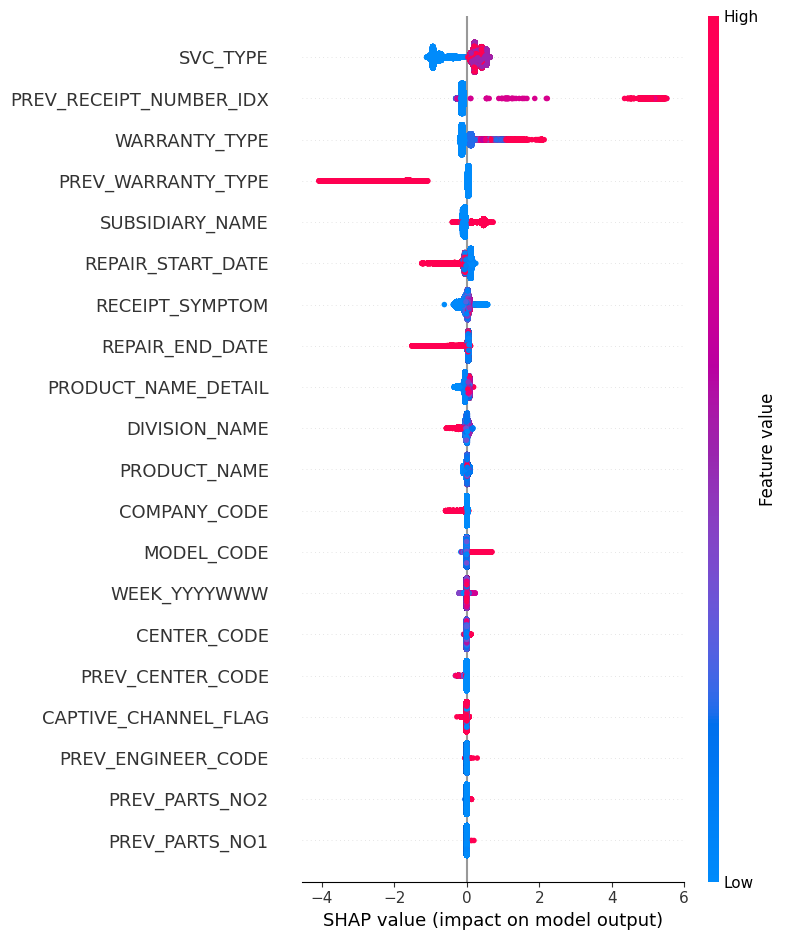

In [6]:
shap.initjs()
xbg_explainer = shap.TreeExplainer(xgb_model)
xbg_shap_values = xbg_explainer.shap_values(X_valid)

shap.summary_plot(xbg_shap_values, X_valid)


In [10]:
shap.force_plot(xbg_explainer.expected_value, xbg_shap_values[0, :], X_valid.iloc[0, :])


In [7]:
import lightgbm as lgb

dt = lgb.Dataset(X_train, label=y_train)
dv = lgb.Dataset(X_valid, label=y_valid)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "early_stopping_round": 50,
}

lgb_model = lgb.train(
    params,
    dt,
    10000,
    valid_sets=[dv],
)


[1]	valid_0's binary_logloss: 0.682182
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.672243
[3]	valid_0's binary_logloss: 0.663233
[4]	valid_0's binary_logloss: 0.655031
[5]	valid_0's binary_logloss: 0.647563
[6]	valid_0's binary_logloss: 0.640736
[7]	valid_0's binary_logloss: 0.634494
[8]	valid_0's binary_logloss: 0.628773
[9]	valid_0's binary_logloss: 0.623534
[10]	valid_0's binary_logloss: 0.618653
[11]	valid_0's binary_logloss: 0.614176
[12]	valid_0's binary_logloss: 0.609963
[13]	valid_0's binary_logloss: 0.60612
[14]	valid_0's binary_logloss: 0.60257
[15]	valid_0's binary_logloss: 0.599252
[16]	valid_0's binary_logloss: 0.596185
[17]	valid_0's binary_logloss: 0.593403
[18]	valid_0's binary_logloss: 0.590765
[19]	valid_0's binary_logloss: 0.588326
[20]	valid_0's binary_logloss: 0.58614
[21]	valid_0's binary_logloss: 0.584003
[22]	valid_0's binary_logloss: 0.581976
[23]	valid_0's binary_logloss: 0.580067
[24]	valid_0's binary_logloss: 

In [18]:
# get the predicted values for the validation set
y_pred_lgb = lgb_model.predict(X_valid)

# convert the predicted values to binary (0 or 1) based on a threshold of 0.5
y_pred_lgb_binary = [1 if x >= 0.5 else 0 for x in y_pred_lgb]

# calculate the accuracy of the model
accuracy = sum(y_pred_lgb_binary == y_valid) / len(y_valid)
print("Accuracy:", accuracy)

# show me the correctnees by 2x2 table
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, y_pred_lgb_binary)


Accuracy: 0.7349493316234789


array([[51656, 19999],
       [18031, 53796]])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


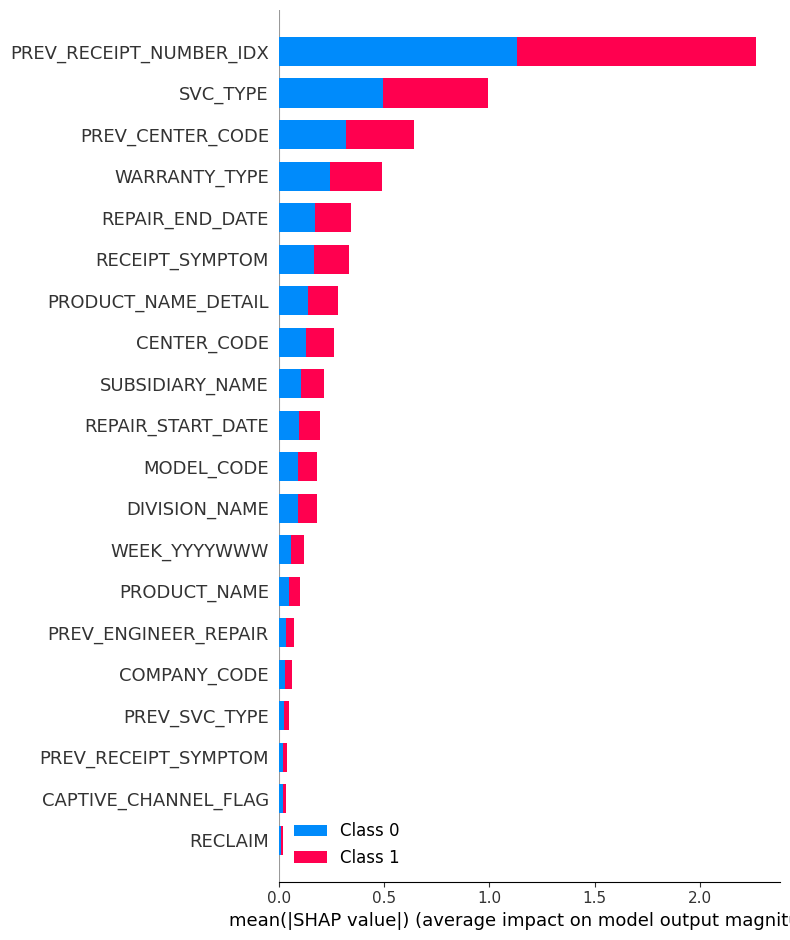

In [8]:
lgb_explainer = shap.TreeExplainer(lgb_model)
lgb_shap_values = lgb_explainer.shap_values(X_valid)

shap.summary_plot(lgb_shap_values, data[features])


In [9]:
shap.force_plot(lgb_explainer.expected_value[1], lgb_shap_values[1][0, :], X_valid.iloc[0, :])


In [11]:
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet_model = TabNetClassifier()
tabnet_model.fit(X_train.values, y_train.values, eval_set=[(X_valid.values, y_valid.values)], patience=10, max_epochs=20)


Device used : cuda


epoch 0  | loss: 0.59964 | val_0_auc: 0.70776 |  0:00:22s
epoch 1  | loss: 0.56511 | val_0_auc: 0.77562 |  0:00:44s
epoch 2  | loss: 0.56171 | val_0_auc: 0.77718 |  0:01:06s
epoch 3  | loss: 0.56013 | val_0_auc: 0.77721 |  0:01:30s
epoch 4  | loss: 0.55948 | val_0_auc: 0.77755 |  0:01:53s
epoch 5  | loss: 0.55982 | val_0_auc: 0.77571 |  0:02:16s
epoch 6  | loss: 0.56014 | val_0_auc: 0.77448 |  0:02:39s
epoch 7  | loss: 0.55926 | val_0_auc: 0.77772 |  0:03:02s
epoch 8  | loss: 0.55814 | val_0_auc: 0.77801 |  0:03:24s
epoch 9  | loss: 0.55762 | val_0_auc: 0.77998 |  0:03:45s
epoch 10 | loss: 0.55768 | val_0_auc: 0.77894 |  0:04:05s
epoch 11 | loss: 0.55716 | val_0_auc: 0.78053 |  0:04:26s
epoch 12 | loss: 0.55667 | val_0_auc: 0.78132 |  0:04:47s
epoch 13 | loss: 0.55626 | val_0_auc: 0.78193 |  0:05:08s
epoch 14 | loss: 0.55642 | val_0_auc: 0.78208 |  0:05:28s
epoch 15 | loss: 0.55519 | val_0_auc: 0.78236 |  0:05:49s
epoch 16 | loss: 0.55419 | val_0_auc: 0.7837  |  0:06:10s
epoch 17 | los

Best weights from best epoch are automatically used!


In [12]:
def tabnet_predict(data):
    return tabnet_model.predict_proba(data)[:, 1]


Permutation explainer: 1001it [07:17,  2.24it/s]                          
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


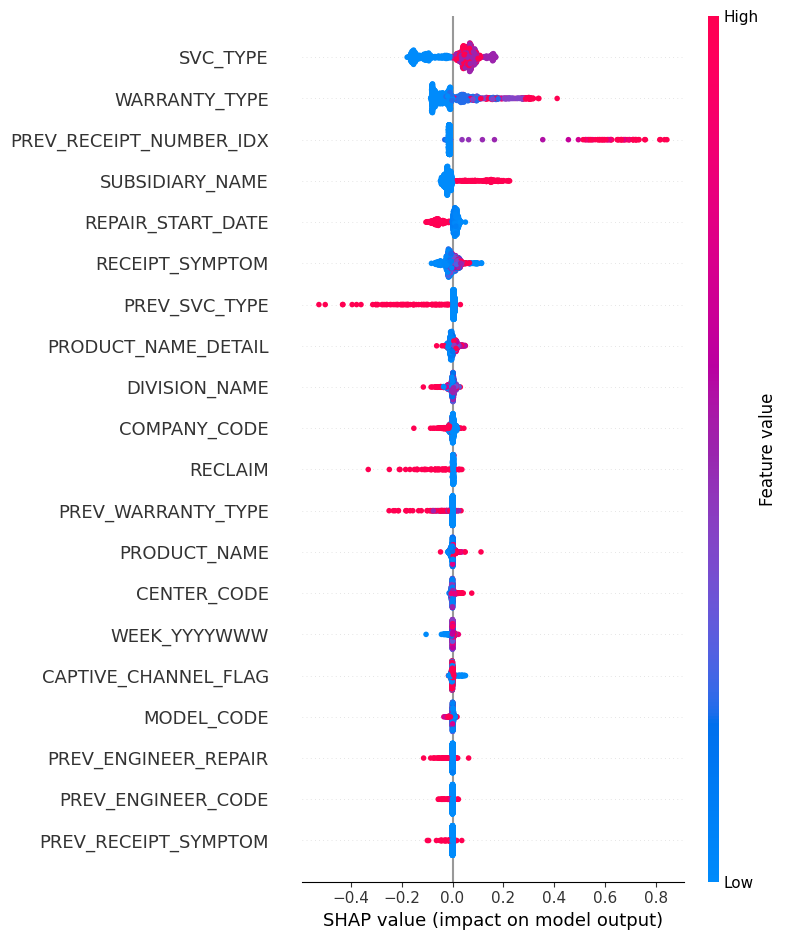

In [13]:
# Explain the model predictions using SHAP
x_valid_sample = X_valid.sample(1000)

tabnet_explainer = shap.Explainer(tabnet_predict, X_train.values)
tabnet_shap_values = tabnet_explainer(x_valid_sample.values)

# Plot the SHAP values
shap.summary_plot(tabnet_shap_values, x_valid_sample, feature_names=X_valid.columns)


In [14]:
# confusion matrix for tabnet
y_pred = tabnet_model.predict(X_valid.values)
accuracy = sum(y_pred == y_valid) / len(y_valid)
print("Accuracy:", accuracy)
confusion_matrix(y_valid, y_pred)


Accuracy: 0.705398586582289


array([[47826, 23829],
       [18441, 53386]])